# Forecasting Time Series data
Idea and some code taken from:

- https://towardsdatascience.com/part-2-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-ii-f09665796c9,
- https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-rnn-full-predict.ipynb#scrollTo=XdfXfXK2-CiG

Some code and approaches from:

- https://github.com/rockey-abhishek/Ausgrid-Dataset
- https://github.com/pierre-haessig/ausgrid-solar-data/blob/master/Pattern_yearly.ipynb
- https://towardsdatascience.com/part-2-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-ii-f09665796c9

## Data

Solar home electricity data with records from 300 customers, with 3 channels for each customer:
- "GC" General Consumption (kW)
- "GG" Gross generation of solar system (kWh)
- "CL" Controller Load Consumption (kW)(Heating Consumption)

Three years of half-hour electricity data (1 July 2010 to 30 June 2013). 



## Purpose:
predict household consumption and PV generation of customers.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import seaborn as sns
import matplotlib.dates as mdates


import matplotlib as mpl
from itertools import combinations

import statsmodels.api as sm

In [3]:
%matplotlib inline

In [4]:
pd.__version__

'0.25.1'

## 1. List of all csv files

In [5]:
path="C:/Users/baatar/Documents/Ausgrid"
allFiles = glob.glob(os.path.join(path, "*.csv")) #Return a possibly-empty list of path names that match pathnam
allFiles

['C:/Users/baatar/Documents/Ausgrid\\Solarhome_2010_2011.csv',
 'C:/Users/baatar/Documents/Ausgrid\\Solarhome_2011_2012.csv',
 'C:/Users/baatar/Documents/Ausgrid\\Solarhome_2012_2013.csv']

##  1.1 Reading csv files into a dict to check contents of each files before concatenate

#### Parse CSV files

In [6]:
#reading in all the csv excel files into a dict
all_files_dic={}
for doc1 in allFiles:
    all_files_dic['Solarhome'+'_'+doc1.strip('.csv')[-4:]]=pd.read_csv(doc1, #reading all csv files into a dict
                            skiprows=1,#skip row=1, which is a PDF link
                            #usecols=range(0,53),
                            parse_dates=['date'], #The 'date' column into datetime format
                            dayfirst=True,   #prepare day is first dtype={'Row Quality': "str"}
                            na_filter=False, #NA is into empty 
                            ) 

In [7]:
#Checking the dict keys
all_files_dic.keys()

dict_keys(['Solarhome_2011', 'Solarhome_2012', 'Solarhome_2013'])

In [8]:
#Checking the head of the data for each file
for keys, items in all_files_dic.items():
    print("\nhead of "+keys+"\n")
    print(items.head())


head of Solarhome_2011

   Customer  Generator Capacity  Postcode Consumption Category       date  \
0         1                3.78      2076                   GC 2010-07-01   
1         1                3.78      2076                   CL 2010-07-01   
2         1                3.78      2076                   GG 2010-07-01   
3         1                3.78      2076                   GC 2010-07-02   
4         1                3.78      2076                   CL 2010-07-02   

    0:30   1:00   1:30   2:00   2:30  ...  19:30  20:00  20:30  21:00  21:30  \
0  0.303  0.471  0.083  0.121  0.361  ...  0.495   0.54  0.406  0.543  0.495   
1  1.250  1.244  1.256  0.744  0.019  ...  0.000   0.00  0.000  0.000  0.000   
2  0.000  0.000  0.000  0.000  0.000  ...  0.000   0.00  0.000  0.000  0.000   
3  0.116  0.346  0.122  0.079  0.120  ...  0.262   1.10  1.012  0.817  0.526   
4  1.238  1.238  1.256  1.250  0.169  ...  0.000   0.00  0.000  0.000  0.000   

   22:00  22:30  23:00  23:30  

In [9]:
#Checking the tail of the data for each file
for keys, items in all_files_dic.items():
    print("\ntail of "+keys+"\n")
    print(items.tail())


tail of Solarhome_2011

        Customer  Generator Capacity  Postcode Consumption Category  \
269730       300                3.36      2086                   CL   
269731       300                3.36      2086                   GG   
269732       300                3.36      2086                   GC   
269733       300                3.36      2086                   CL   
269734       300                3.36      2086                   GG   

             date   0:30   1:00   1:30   2:00   2:30  ...  19:30  20:00  \
269730 2011-06-29  2.136  0.000  0.000  0.000  0.000  ...  0.000  0.000   
269731 2011-06-29  0.000  0.000  0.000  0.000  0.000  ...  0.000  0.000   
269732 2011-06-30  1.306  0.851  0.113  0.151  0.104  ...  0.948  0.917   
269733 2011-06-30  0.904  0.000  0.000  0.000  0.000  ...  0.000  0.000   
269734 2011-06-30  0.000  0.000  0.000  0.000  0.000  ...  0.000  0.000   

        20:30  21:00  21:30  22:00  22:30  23:00  23:30   0:00  
269730  0.000  0.000  0.000  0.0

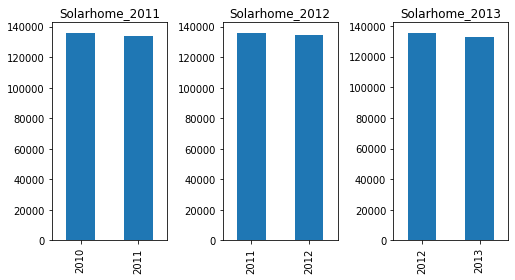

In [10]:
#Checking the number of rows in this year in this files
plt.figure(figsize = (12,4))
for i, (keys, items) in enumerate(all_files_dic.items()):
    ax = plt.subplot(151+i)
    items['date'].dt.year.value_counts().plot(kind='bar', subplots = True, ax = ax)
    ax.set_title("{}".format(keys))
plt.tight_layout()

## 2. Creating a time series DataFrame 
Read raw data in dataframe

In [11]:
d_raw = pd.DataFrame()
d_raw = pd.concat(   # For future use, I want to use 3 csv files
                    [pd.read_csv(file, 
                            skiprows=1,#skip row=1, which is a PDF link
                            parse_dates=['date'], 
                            dayfirst=True,
                            dtype={'Row Quality': str},
                            na_filter=False, #NA is into empty 
                            ) for file in allFiles ], 
                ignore_index=True, #concatenation to ignore existing indices, Then, the resulting DataFrame index will be labeled with 0 , …, n-1 
                sort=False)
print(d_raw.shape)

(808596, 54)


### Overview

rows seems ordered by: Customer / Consumption Category / date

In [12]:
d_raw.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,GC,2010-07-01,0.303,0.471,0.083,0.121,0.361,...,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125,NaN
1,1,3.78,2076,CL,2010-07-01,1.250,1.244,1.256,0.744,0.019,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075,NaN
2,1,3.78,2076,GG,2010-07-01,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,GC,2010-07-02,0.116,0.346,0.122,0.079,0.120,...,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111,NaN
4,1,3.78,2076,CL,2010-07-02,1.238,1.238,1.256,1.250,0.169,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088,NaN


In [13]:
d_raw.tail()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
808591,300,3.36,2086,GC,2013-06-29,0.171,0.832,0.440,0.745,0.149,...,0.383,0.404,0.367,0.398,0.350,0.228,0.170,0.139,0.171,
808592,300,3.36,2086,GG,2013-06-29,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,
808593,300,3.36,2086,CL,2013-06-30,2.501,2.475,2.491,2.508,2.490,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.468,
808594,300,3.36,2086,GC,2013-06-30,0.150,0.158,0.157,0.137,0.163,...,0.625,0.595,0.695,0.646,0.581,0.458,0.472,0.732,0.297,
808595,300,3.36,2086,GG,2013-06-30,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,


##  2.1 Data Cleaning 

#### Dates

* `parse_date` option is working (although quite slow)
* `dayfirst=True` is needed to avoid date inversions

In [14]:
d_raw.date.head()

0   2010-07-01
1   2010-07-01
2   2010-07-01
3   2010-07-02
4   2010-07-02
Name: date, dtype: datetime64[ns]

In [15]:
%time min(d_raw.date)

Wall time: 2.02 s


Timestamp('2010-07-01 00:00:00')

In [16]:
%time d_raw.date.min()

Wall time: 6 ms


Timestamp('2010-07-01 00:00:00')

In [17]:
d0, d1 = d_raw.date.min(), d_raw.date.max()
d0, d1

(Timestamp('2010-07-01 00:00:00'), Timestamp('2013-06-30 00:00:00'))

#### Row Quality:

Ausgrid description:
> (Blank) = every half hour value in the row is the actual electricity
recorded by the meter in the half hour
>
> NA = Non-Actual where some or all of the half hour values in the
row are estimates or substitutes of the electricity consumed or
generated

Specifying the `dtype={'Row Quality': str}` is needed to avoid a columns of dtype float, filled with NaN.

In [18]:
d_raw['Row Quality'].unique()

array([nan, '', 'NA'], dtype=object)

In [19]:
d_raw['Row Quality'].value_counts()

      538330
NA       531
Name: Row Quality, dtype: int64

#### Customers

300 unique values, from 1 to 300

In [20]:
len(d_raw['Customer'].unique())

300

In [21]:
d_raw['Customer'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

#### Consumption Category (aka measurement channel)

From Ausgrid description:

> **GC** = General Consumption for electricity supplied all the time
(primary tariff, either inclining block or time of use rates),
excluding solar generation and controlled load supply

> **CL** = Controlled Load Consumption (Off peak 1 or 2 tariffs)

> **GG** = Gross Generation for electricity generated by the solar
system with a gross metering configuration, measured separately
to household loads

Observation: only half as much CL as GG and GC.


In [22]:
d_raw['Consumption Category'].unique()

array(['GC', 'CL', 'GG'], dtype=object)

In [23]:
d_raw['Consumption Category'].value_counts()

GC    328719
GG    328719
CL    151158
Name: Consumption Category, dtype: int64

### Completeness of the record

there are some missing records in the dataframe:

* GG and GC is almost complete, 1-2 datas are missing, we will check them at chapter 3.2
* Some 54% of CL is missing.

In [24]:
len(d_raw)/1095/300

2.4614794520547947

In [25]:
d_raw['Consumption Category'].value_counts()/300/1095

GC    1.000667
GG    1.000667
CL    0.460146
Name: Consumption Category, dtype: float64

## 3. Reshaping the data set

Objective:

* Stack the time, to get proper timestamp combining day and hour
* pivot the customer and consumption category as columns

#### Create datetime index with proper timestamp combining day and hour

In [26]:
from pandas.tseries.offsets import Day

In [27]:
d1

Timestamp('2013-06-30 00:00:00')

In [28]:
d1 + Day(1)

Timestamp('2013-07-01 00:00:00')

Create the index, with **"left" convention** (start of the 30min interval), to make slicing for a given day easier

In [29]:
index = pd.date_range(d0, d1 + Day(1), freq='30T', closed='left')
index

DatetimeIndex(['2010-07-01 00:00:00', '2010-07-01 00:30:00',
               '2010-07-01 01:00:00', '2010-07-01 01:30:00',
               '2010-07-01 02:00:00', '2010-07-01 02:30:00',
               '2010-07-01 03:00:00', '2010-07-01 03:30:00',
               '2010-07-01 04:00:00', '2010-07-01 04:30:00',
               ...
               '2013-06-30 19:00:00', '2013-06-30 19:30:00',
               '2013-06-30 20:00:00', '2013-06-30 20:30:00',
               '2013-06-30 21:00:00', '2013-06-30 21:30:00',
               '2013-06-30 22:00:00', '2013-06-30 22:30:00',
               '2013-06-30 23:00:00', '2013-06-30 23:30:00'],
              dtype='datetime64[ns]', length=52608, freq='30T')

#### Create multindexing(Hierarchical indexing) : Customer/Channel

using a MultiIndex, cf. [MultiIndex / Advanced Indexing](http://pandas.pydata.org/pandas-docs/stable/advanced.html) doc.

In [30]:
customers = sorted(d_raw.Customer.unique())
print(customers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [31]:
channels = d_raw['Consumption Category'].unique()
channels

array(['GC', 'CL', 'GG'], dtype=object)

Customized channel order:

* Consumption first (GC)
* PV Generation second (GG)
* CL third, because it is not always present (small trick to preserve the channel color in plots)

In [32]:
channels = ['GC', 'GG', 'CL']

In [33]:
columns = pd.MultiIndex.from_product(
    (customers, channels), names=['Customer', 'Channel'])
columns

MultiIndex([(  1, 'GC'),
            (  1, 'GG'),
            (  1, 'CL'),
            (  2, 'GC'),
            (  2, 'GG'),
            (  2, 'CL'),
            (  3, 'GC'),
            (  3, 'GG'),
            (  3, 'CL'),
            (  4, 'GC'),
            ...
            (297, 'CL'),
            (298, 'GC'),
            (298, 'GG'),
            (298, 'CL'),
            (299, 'GC'),
            (299, 'GG'),
            (299, 'CL'),
            (300, 'GC'),
            (300, 'GG'),
            (300, 'CL')],
           names=['Customer', 'Channel'], length=900)

## 3.1 Create the new DataFrame with new datetime index and hierarchical index
starting from a blank DataFrame:

In [34]:
empty_cols = pd.MultiIndex(
    levels=[customers, channels],
    labels=[[],[]],
    names=['Customer', 'Channel'])

C:\Users\baatar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  after removing the cwd from sys.path.


In [35]:
df = pd.DataFrame(index=index, columns=empty_cols)
df

2010-07-01 00:00:00
2010-07-01 00:30:00
2010-07-01 01:00:00
2010-07-01 01:30:00
2010-07-01 02:00:00
...
2013-06-30 21:30:00
2013-06-30 22:00:00
2013-06-30 22:30:00
2013-06-30 23:00:00
2013-06-30 23:30:00


## 3.2 Data Cleaning

### 3.2.1 Fill the columns:

notice: 

* it is way slower when the 3x300 columns are pre-assigned in the DataFrame creation
* but the MultiIndex is lost when pre-assignment is not done (empty columns)
* → solution which seems to work: using an empty MultiIndex (customers/channel)

In [36]:
missing_records = []

for c in customers:
    d_c = d_raw[d_raw.Customer == c]
    
    # TODO: save the row quality
    print(c, end=', ')
    
    for ch in channels:
        d_c_ch = d_c[d_c['Consumption Category'] == ch]
        ts = d_c_ch.iloc[:,5:-1].values.ravel()
        if len(ts) != len(index):
            missing_records.append((c,ch, len(ts)))
        else:
            df[c, ch] = ts

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

### 3.2.2 Analysis of missing/imcomplete records

Observation: out of 162 missing records (over a potential of 900):

* 161 are the complete absence of the CL channel
* 1 is an incomplete CL channe (from 2011-07-01 to 2012-01-12): maybe a change of tariff ?

In [37]:
len(columns)

900

In [38]:
len(missing_records)

175

In [39]:
n_empty_CL = 0
missing_records_others = []
for (c, ch, len_ts) in missing_records:
    if ch=='CL' and len_ts==0:
        n_empty_CL += 1
    else:
        missing_records_others.append((c, ch, len_ts))
n_empty_CL

161

In [40]:
missing_records_others

[(2, 'GC', 48720),
 (2, 'GG', 48720),
 (2, 'CL', 48720),
 (27, 'CL', 26928),
 (68, 'CL', 49488),
 (95, 'CL', 50352),
 (161, 'CL', 49776),
 (187, 'CL', 49824),
 (248, 'CL', 50448),
 (272, 'CL', 49488),
 (284, 'CL', 49488),
 (289, 'CL', 49728),
 (293, 'CL', 50304),
 (294, 'CL', 49824)]

In [41]:
d_27_CL = d_raw[(d_raw.Customer == 27) & (d_raw['Consumption Category'] == 'CL')]
d_27_CL['date'].iloc[[0,-1]]

24456    2010-07-01
294842   2012-01-12
Name: date, dtype: datetime64[ns]

### 3.3 Overview of new dataframe

In [42]:
len(df.columns) + len(missing_records)

900

In [43]:
df.head()

Customer               1                  3                  4                \
Channel                 GC   GG     CL     GC   GG     CL     GC   GG     CL   
2010-07-01 00:00:00  0.303  0.0  1.250  0.669  0.0  2.029  0.075  0.0  0.000   
2010-07-01 00:30:00  0.471  0.0  1.244  0.671  0.0  2.013  0.086  0.0  0.000   
2010-07-01 01:00:00  0.083  0.0  1.256  0.675  0.0  1.000  0.085  0.0  1.973   
2010-07-01 01:30:00  0.121  0.0  0.744  0.683  0.0  0.000  0.084  0.0  1.950   
2010-07-01 02:00:00  0.361  0.0  0.019  0.694  0.0  0.000  0.084  0.0  1.544   

Customer             5    ...    297              298         299         300  \
Channel               GC  ...     GC   GG   CL     GC   GG     GC   GG     GC   
2010-07-01 00:00:00  0.0  ...  0.205  0.0  0.0  0.096  0.0  1.464  0.0  0.279   
2010-07-01 00:30:00  0.0  ...  0.106  0.0  0.0  0.110  0.0  1.413  0.0  0.924   
2010-07-01 01:00:00  0.0  ...  0.169  0.0  0.0  0.080  0.0  1.428  0.0  0.803   
2010-07-01 01:30:00  0.0  ...  0.270  0.0  0.0  0.105  0.0  1.445  0.0  0.066   
2010-07-01 02:00:00  0.0  ...  0.255  0.0  0.0  0.089  0.0  1.407  0.0  0.089   

Customer                         
Channel               GG     CL  
2010-07-01 00:00:00  0.0  2.487  
2010-07-01 00:30:00  0.0  2.392  
2010-07-01 01:00:00  0.0  1.285  
2010-07-01 01:30:00  0.0  0.000  
2010-07-01 02:00:00  0.0  0.000  

[5 rows x 725 columns]

In [44]:
df.tail()

Customer               1                  3                4              \
Channel                 GC   GG     CL     GC   GG   CL     GC   GG   CL   
2013-06-30 21:30:00  0.274  0.0  0.000  0.056  0.0  0.0  0.134  0.0  0.0   
2013-06-30 22:00:00  0.509  0.0  0.000  0.056  0.0  0.0  0.137  0.0  0.0   
2013-06-30 22:30:00  0.166  0.0  0.000  0.065  0.0  0.0  0.140  0.0  0.0   
2013-06-30 23:00:00  0.861  0.0  0.000  0.063  0.0  0.0  0.112  0.0  0.0   
2013-06-30 23:30:00  0.631  0.0  1.056  0.052  0.0  0.0  0.107  0.0  0.0   

Customer               5    ...    297                298         299       \
Channel                 GC  ...     GC   GG     CL     GC   GG     GC   GG   
2013-06-30 21:30:00  0.390  ...  0.167  0.0  0.000  0.267  0.0  0.618  0.0   
2013-06-30 22:00:00  0.413  ...  0.179  0.0  0.775  0.273  0.0  0.568  0.0   
2013-06-30 22:30:00  1.068  ...  0.181  0.0  2.413  0.247  0.0  0.832  0.0   
2013-06-30 23:00:00  1.084  ...  0.171  0.0  1.095  0.149  0.0  0.760  0.0   
2013-06-30 23:30:00  0.999  ...  0.177  0.0  0.000  0.138  0.0  0.150  0.0   

Customer               300              
Channel                 GC   GG     CL  
2013-06-30 21:30:00  0.581  0.0  0.000  
2013-06-30 22:00:00  0.458  0.0  0.000  
2013-06-30 22:30:00  0.472  0.0  0.000  
2013-06-30 23:00:00  0.732  0.0  0.000  
2013-06-30 23:30:00  0.297  0.0  2.468  

[5 rows x 725 columns]

In [45]:
df[1].mean()

Channel
GC    0.314470
GG    0.279587
CL    0.140485
dtype: float64

In [46]:
df *= 2

In [47]:
df[1].mean()

Channel
GC    0.628939
GG    0.559175
CL    0.280969
dtype: float64

### 3.3.1 Howto work with the reshaped DataFrame

#### MultiIndexing_First Level 

- select *one* customer, with all its 3 channels

this easy because `customer` is the first level of the MultiIndex

In [48]:
df[1]

Channel,GC,GG,CL
2010-07-01 00:00:00,0.606,0.0,2.500
2010-07-01 00:30:00,0.942,0.0,2.488
2010-07-01 01:00:00,0.166,0.0,2.512
2010-07-01 01:30:00,0.242,0.0,1.488
2010-07-01 02:00:00,0.722,0.0,0.038
...,...,...,...
2013-06-30 21:30:00,0.548,0.0,0.000
2013-06-30 22:00:00,1.018,0.0,0.000
2013-06-30 22:30:00,0.332,0.0,0.000
2013-06-30 23:00:00,1.722,0.0,0.000


In [49]:
df[1].mean()

Channel
GC    0.628939
GG    0.559175
CL    0.280969
dtype: float64

#### MultiIndexing_Second Level 
- select one channel, across all customers

This is less easy because channel is the 2nd level of the MultiIndex. It requires using cross-section indexing with xs

In [50]:
dfGG = df.xs('GC', level='Channel', axis=1)
dfGG[[1, 4, 100]].head()

Customer,1,4,100
2010-07-01 00:00:00,0.606,0.150,0.850
2010-07-01 00:30:00,0.942,0.172,0.938
2010-07-01 01:00:00,0.166,0.170,0.888
2010-07-01 01:30:00,0.242,0.168,0.950
2010-07-01 02:00:00,0.722,0.168,0.988


#### Time-based indexing vs Multiindexing_First_Level

In [51]:
df[1]['2011-07-01']

Channel,GC,GG,CL
2011-07-01 00:00:00,2.154,0.000,2.500
2011-07-01 00:30:00,1.338,0.000,2.500
2011-07-01 01:00:00,1.348,0.000,2.500
2011-07-01 01:30:00,1.230,0.000,1.250
2011-07-01 02:00:00,0.642,0.000,0.438
2011-07-01 02:30:00,0.194,0.000,2.026
2011-07-01 03:00:00,1.054,0.000,0.000
2011-07-01 03:30:00,0.140,0.000,0.000
2011-07-01 04:00:00,0.098,0.000,0.250
2011-07-01 04:30:00,0.170,0.000,1.788


## 4. Visualizing time series data
### Charts in Matplotlib
#### Customer daily pattern: 
- "GC" General Consumption (kW)
- "GG" Gross generation of solar system (kWh)
- "CL" Controller Load Consumption (kW)(Heating Consumption)

Text(0, 0.5, 'kW')

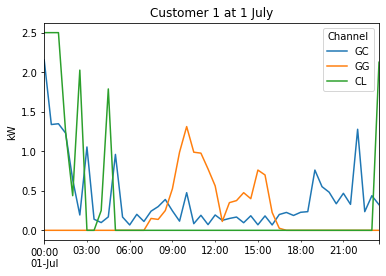

In [52]:
df[1]['2011-07-01':'2011-07-01'].plot()
plt.title('Customer 1 at 1 July')
plt.ylabel('kW')

## 5. TIme Series Components
- Level: 
- Trend : Trend is increases? decreases?, or remains at a constant level? 
- Seasonality: displays periodical patterns that repeats at a constant frequency (m) /Cycles:Cycles are seasons that do not occur at a fixed rate
- Noise

#### Let’s add some column to df, containing the year, month, and weekday name

In [53]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name']=df.index.weekday_name
df.head()

Customer                 1                  3                  4              \
Channel                 GC   GG     CL     GC   GG     CL     GC   GG     CL   
2010-07-01 00:00:00  0.606  0.0  2.500  1.338  0.0  4.058  0.150  0.0  0.000   
2010-07-01 00:30:00  0.942  0.0  2.488  1.342  0.0  4.026  0.172  0.0  0.000   
2010-07-01 01:00:00  0.166  0.0  2.512  1.350  0.0  2.000  0.170  0.0  3.946   
2010-07-01 01:30:00  0.242  0.0  1.488  1.366  0.0  0.000  0.168  0.0  3.900   
2010-07-01 02:00:00  0.722  0.0  0.038  1.388  0.0  0.000  0.168  0.0  3.088   

Customer               5  ...    298         299         300              \
Channel               GC  ...     GC   GG     GC   GG     GC   GG     CL   
2010-07-01 00:00:00  0.0  ...  0.192  0.0  2.928  0.0  0.558  0.0  4.974   
2010-07-01 00:30:00  0.0  ...  0.220  0.0  2.826  0.0  1.848  0.0  4.784   
2010-07-01 01:00:00  0.0  ...  0.160  0.0  2.856  0.0  1.606  0.0  2.570   
2010-07-01 01:30:00  0.0  ...  0.210  0.0  2.890  0.0  0.132  0.0  0.000   
2010-07-01 02:00:00  0.0  ...  0.178  0.0  2.814  0.0  0.178  0.0  0.000   

Customer             Year Month Weekday Name  
Channel                                       
2010-07-01 00:00:00  2010     7     Thursday  
2010-07-01 00:30:00  2010     7     Thursday  
2010-07-01 01:00:00  2010     7     Thursday  
2010-07-01 01:30:00  2010     7     Thursday  
2010-07-01 02:00:00  2010     7     Thursday  

[5 rows x 728 columns]

### 5.1 Daily Pattern
Daily pattern of general (uncontrolled) consumption
- "GC" General Consumption (kW)

#### Using mdates

NameError: name 'dfGC' is not defined

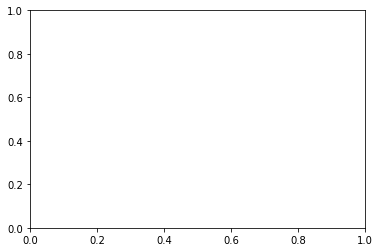

In [55]:
fig, ax = plt.subplots()
ax.plot(dfGC[[1]]['2011-07-05':'2011-07-11'], linestyle='-')
ax.set_ylabel('Daily PV generation (GWh)')
ax.set_title('one Week Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

#### Using our reshaped dataframe

In [61]:
dfGC = df.xs('GC', level='Channel', axis=1)
dfCL = df.xs('CL', level='Channel', axis=1)

In [62]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

dfGC_dpat = dfGC.groupby(by=hod).mean()

In [63]:
dfGC_dpat

Customer,1,3,4,5,6,7,8,9,10,11,...,291,292,293,294,295,296,297,298,299,300
0.0,0.669175,0.326307,0.239810,0.270668,0.512951,0.291808,0.344002,0.086945,0.255422,0.455622,...,0.834328,0.141044,0.417641,0.567505,0.372816,0.114608,0.474250,0.261560,0.460668,1.275597
0.5,0.534591,0.277734,0.230327,0.250577,0.487363,0.257162,0.313179,0.084715,0.239285,0.365527,...,0.759372,0.132292,0.565995,0.607951,0.313221,0.109432,0.471790,0.230396,0.399602,1.079349
1.0,0.531584,0.245166,0.223836,0.241480,0.473828,0.233370,0.307920,0.080920,0.232381,0.335458,...,0.668319,0.148754,0.489071,0.627982,0.282951,0.108168,0.462232,0.203609,0.375549,0.898810
1.5,0.476385,0.225201,0.227142,0.227697,0.476040,0.227812,0.294088,0.081111,0.220312,0.322206,...,0.599057,0.144905,0.494111,0.598655,0.239533,0.104080,0.454051,0.188453,0.366042,0.635018
2.0,0.454693,0.204226,0.224159,0.221159,0.475637,0.231438,0.294261,0.077016,0.215217,0.307427,...,0.551998,0.157989,0.544328,0.555544,0.215566,0.102750,0.444283,0.179168,0.365400,0.449276
2.5,0.472577,0.197589,0.228730,0.215666,0.484894,0.226190,0.288768,0.075372,0.205958,0.301558,...,0.527938,0.164159,0.624998,0.491354,0.188998,0.102726,0.433226,0.175743,0.360193,0.458186
3.0,1.430020,0.192283,0.228958,0.208458,0.489611,0.232588,0.283261,0.072582,0.202951,0.305484,...,0.512697,0.159620,0.675027,0.459396,0.178938,0.099440,0.428524,0.174036,0.361356,0.447982
3.5,1.124666,0.187852,0.227938,0.206093,0.494418,0.232328,0.280464,0.073215,0.196580,0.297971,...,0.501600,0.168383,0.930261,0.427538,0.170487,0.100033,0.414170,0.169577,0.355542,0.380712
4.0,0.643619,0.189836,0.226040,0.207035,0.506089,0.233985,0.276651,0.071874,0.194022,0.294458,...,0.493474,0.185133,1.063040,0.450973,0.168285,0.097880,0.406498,0.167055,0.360102,0.363367
4.5,0.531349,0.195405,0.226861,0.232314,0.514684,0.232679,0.273628,0.072099,0.191290,0.291641,...,0.485480,0.179179,1.309911,0.514876,0.165765,0.098058,0.403911,0.167723,0.347321,0.364664


In [64]:
#import matplotlib as mpl
loc_6h = mpl.ticker.MultipleLocator(6)

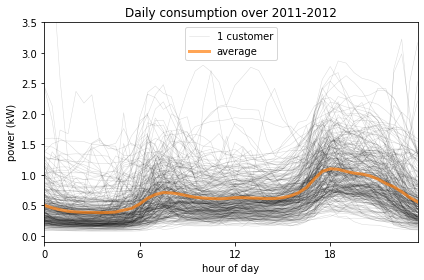

In [65]:
ax = dfGC_dpat.plot(color='k', alpha=0.15, lw=0.5)
dfGC_dpat.mean(axis=1).plot(color='tab:orange', lw=3, alpha=0.7)

ax.xaxis.set_major_locator(loc_6h)
plt.legend(ax.lines[-2:], ['1 customer', 'average'])
ax.set(
    xlabel='hour of day',
    ylabel='power (kW)',
    ylim=(-0.1, 3.5),
    title='Daily consumption over 2011-2012'
    );

plt.tight_layout()
plt.savefig('GC_day.png', dpi=150);

#### 5.2 Seasonality pattern
We’ll first group the data by month, to visualize yearly seasonality.



#### ToDO  Using boxplot

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['', '', ''], axes):
sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
ax.set_ylabel('GWh')
ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

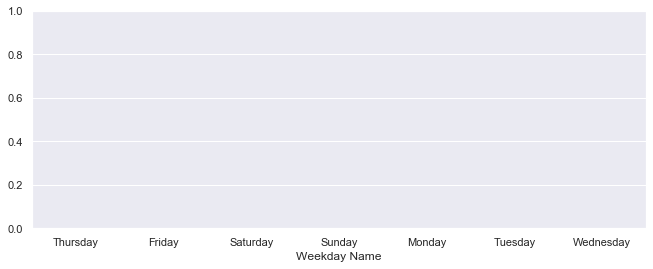

In [242]:
sns.boxplot(data=df, x='Weekday Name', y=[df[1]['2011-07-01':'2011-08-01']]); 

### 5.3 Level
#### Consumption average:

In [66]:
dt = 0.5 # hours
GC_year = dfGC.sum()*dt
CL_year = dfCL.sum()*dt

GC_year.mean(), CL_year.mean(), GC_year.mean()+  CL_year.mean(), (GC_year +  CL_year).mean()

(17425.44823076917, 5515.924952755908, 22941.373183525076, 21068.014779527537)

In [67]:
GC_year

Customer
1      16543.623
3       7788.634
4      10790.457
5      10713.208
6      23593.418
         ...    
296     8665.764
297    15737.325
298     9882.531
299    29469.815
300    28452.647
Length: 299, dtype: float64

In [68]:
len(CL_year), len(GC_year)

(127, 299)

In [69]:
GC_year +  CL_year

Customer
1      23934.233
3      10187.981
4      15896.838
5      15192.079
6      33185.479
         ...    
296          NaN
297    21659.819
298          NaN
299          NaN
300    39198.702
Length: 299, dtype: float64

In [70]:
Cons_y = pd.DataFrame({'GCy': GC_year, 'CLy':  CL_year})
Cons_y.sum(axis=1)

1      23934.233
3      10187.981
4      15896.838
5      15192.079
6      33185.479
         ...    
296     8665.764
297    21659.819
298     9882.531
299    29469.815
300    39198.702
Length: 299, dtype: float64

#### average 9884 kWh:

In [71]:
Cons_y.sum(axis=1).mean()

19768.332742474846

#### Consumtion Max:

In [72]:
Cons = dfGC.add(dfCL, fill_value=0) 
Cons.max().describe()

count    299.000000
mean       7.770582
std        2.254385
min        2.986000
25%        6.285000
50%        7.604000
75%        8.975000
max       15.610000
dtype: float64

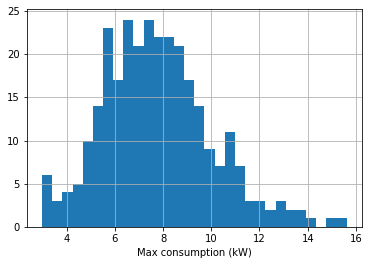

In [73]:
Cons.max().hist(bins=30)
plt.xlabel('Max consumption (kW)');

### 5.4 Fequencies

## 6.Correlation across PV productions

In [74]:
pv_corr = dfGG.corr()

In [75]:
pv_corr.iloc[0:5,0:5]

Customer,1,3,4,5,6
Customer,,,,,
1,1.000000,0.032729,-0.031747,-0.027416,-0.031753
3,0.032729,1.000000,0.110191,0.054232,0.188313
4,-0.031747,0.110191,1.000000,0.168252,0.232660
5,-0.027416,0.054232,0.168252,1.000000,0.230579
6,-0.031753,0.188313,0.232660,0.230579,1.000000


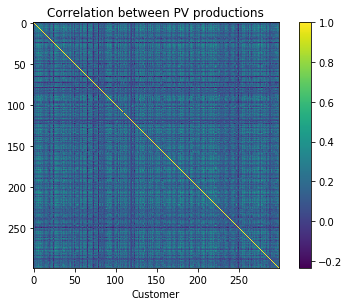

In [84]:
plt.imshow(pv_corr)
plt.colorbar()
plt.tight_layout()
plt.xlabel('Customer')
plt.title('Correlation between PV productions');

In [85]:
cust_code = d_raw.groupby('Customer')['Postcode'].min()
cust_code.value_counts()

2259    28
2261    21
2290    13
2093     9
2262     8
        ..
2296     1
2162     1
2154     1
2046     1
2047     1
Name: Postcode, Length: 100, dtype: int64

In [88]:
def great_circle(latlong1, latlong2):
    '''great circle distance between two points on a spherical earth
    
    longitudes and latitudes in degrees. Distance in km.
    '''
    R = 6371 # km
    d2r = np.deg2rad
    from numpy import cos, sin, arcsin, sqrt
    
    lat1, lng1 = latlong1
    lat2, lng2 = latlong2
    dlat = d2r(lat2 - lat1)
    dlng = d2r(lng2 - lng1)
    
    cos12 = cos(d2r(lat1))*cos(d2r(lat2))
                       
    a = sin(dlat/2)**2 + cos12*np.sin(dlng/2)**2
    ang = 2*arcsin(sqrt(a))
    return R*ang

cities = {
    'Newcastle': (-32.933, 151.733),
    'Cessnock': (-32.834, 151.3555),
    'Gosford': (-33.433, 151.33),
    'Sydney':  (-33.856, 151.1925),
    'Paris': (48.8571, 2.35191),
    'Rennes': (48.11449, -1.67902)
}
#great_circle(cities['Rennes'], cities['Paris']) # check 309 km
great_circle(cities['Newcastle'], cities['Sydney']), great_circle(cities['Newcastle'], cities['Cessnock'])

(114.24202913650407, 36.92938804535449)

In [89]:
pv_corr_flat = []
for (c1, c2) in combinations(customers, 2):
    p1, p2 = cust_code[c1], cust_code[c2]
    d = great_circle(
        (df_pcodes.loc[p1][['lat','lng']]),
        (df_pcodes.loc[p2][['lat','lng']]),
        )
    pv_corr_flat.append([c1, c2, pv_corr.loc[c1,c2], p1, p2, d])

NameError: name 'df_pcodes' is not defined

In [90]:
df_pv_corr = pd.DataFrame(pv_corr_flat, columns=['c1', 'c2', 'corr12', 'c1_code', 'c2_code', 'd_km'])
df_pv_corr

,c1,c2,corr12,c1_code,c2_code,d_km


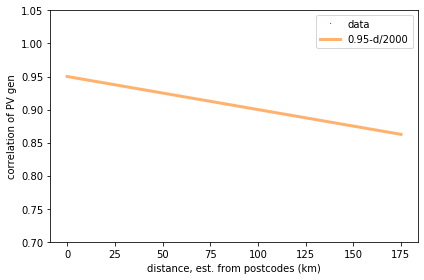

In [91]:
plt.plot(df_pv_corr.d_km, df_pv_corr.corr12, ',', alpha=1, label='data')

d = np.linspace(0, 175)
plt.plot(d, 0.95-d/2000, lw=3, alpha=0.6, label='0.95-d/2000')

plt.legend()
plt.ylim(0.7, 1.05)
plt.xlabel('distance, est. from postcodes (km)')
plt.ylabel('correlation of PV gen');
plt.tight_layout()
plt.savefig('PV corr distance.png', dpi=150)

## 6. Time Series Predictors

## Can we predict each day's consumption from its past?
We train on the years 2010 - 2013 and validate on 2014

In [1]:
consumption_customer1=dfGC[[1]]

NameError: name 'dfGC' is not defined

In [307]:
consumption_customer1.shape

(52608, 1)

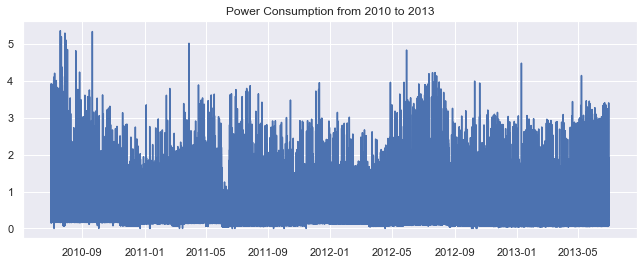

In [310]:
plt.title('Power Consumption from 2010 to 2013')
plt.plot(consumption_customer1);

## 6.1 Statistical Methods directly geared towards forecasting

In [326]:
#import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(['2013-07-01':'2013-07-11']dfGC[[1]], model='additive')
decomposition.plot();

SyntaxError: invalid syntax (<ipython-input-326-30bc60943043>, line 2)